# 质谱数据处理流程详解

本notebook详细解释从谱库构建特征矩阵的完整流程

## 1. 环境准备和数据模拟

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)

## 2. 模拟谱库数据

首先创建一个简化的谱库数据来理解处理流程

In [2]:
# 创建模拟的谱库数据
def create_mock_library():
    # 模拟3个前体离子，每个有6个片段
    data = []
    
    # 前体离子1: PEPTIDE1+2
    precursor1 = {
        'transition_group_id': 'PEPTIDE1+2',
        'PeptideSequence': 'PEPTIDE1',
        'PrecursorMz': 500.25,
        'PrecursorCharge': 2,
        'Tr_recalibrated': 25.5,
        'decoy': 0
    }
    
    # 为前体离子1添加6个片段
    fragments1 = [
        {'ProductMz': 147.11, 'FragmentCharge': 1, 'FragmentType': 1, 'LibraryIntensity': 100},  # b1
        {'ProductMz': 244.17, 'FragmentCharge': 1, 'FragmentType': 1, 'LibraryIntensity': 80},   # b2
        {'ProductMz': 357.25, 'FragmentCharge': 1, 'FragmentType': 2, 'LibraryIntensity': 120},  # y3
        {'ProductMz': 454.31, 'FragmentCharge': 1, 'FragmentType': 2, 'LibraryIntensity': 150},  # y4
        {'ProductMz': 567.39, 'FragmentCharge': 1, 'FragmentType': 2, 'LibraryIntensity': 200},  # y5
        {'ProductMz': 664.45, 'FragmentCharge': 1, 'FragmentType': 2, 'LibraryIntensity': 90},   # y6
    ]
    
    for frag in fragments1:
        row = {**precursor1, **frag}
        data.append(row)
    
    # 前体离子2: PEPTIDE2+3
    precursor2 = {
        'transition_group_id': 'PEPTIDE2+3',
        'PeptideSequence': 'PEPTIDE2',
        'PrecursorMz': 433.56,
        'PrecursorCharge': 3,
        'Tr_recalibrated': 30.2,
        'decoy': 0
    }
    
    fragments2 = [
        {'ProductMz': 175.12, 'FragmentCharge': 1, 'FragmentType': 1, 'LibraryIntensity': 110},
        {'ProductMz': 262.15, 'FragmentCharge': 1, 'FragmentType': 1, 'LibraryIntensity': 85},
        {'ProductMz': 391.21, 'FragmentCharge': 1, 'FragmentType': 2, 'LibraryIntensity': 130},
        {'ProductMz': 504.26, 'FragmentCharge': 1, 'FragmentType': 2, 'LibraryIntensity': 170},
    ]
    
    for frag in fragments2:
        row = {**precursor2, **frag}
        data.append(row)
    
    return pd.DataFrame(data)

# 创建模拟数据
mock_library = create_mock_library()
print("模拟的谱库数据：")
display(mock_library)

模拟的谱库数据：


,transition_group_id,PeptideSequence,PrecursorMz,PrecursorCharge,Tr_recalibrated,decoy,ProductMz,FragmentCharge,FragmentType,LibraryIntensity
0,PEPTIDE1+2,PEPTIDE1,500.25,2,25.5,0,147.11,1,1,100
1,PEPTIDE1+2,PEPTIDE1,500.25,2,25.5,0,244.17,1,1,80
2,PEPTIDE1+2,PEPTIDE1,500.25,2,25.5,0,357.25,1,2,120
3,PEPTIDE1+2,PEPTIDE1,500.25,2,25.5,0,454.31,1,2,150
4,PEPTIDE1+2,PEPTIDE1,500.25,2,25.5,0,567.39,1,2,200
5,PEPTIDE1+2,PEPTIDE1,500.25,2,25.5,0,664.45,1,2,90
6,PEPTIDE2+3,PEPTIDE2,433.56,3,30.2,0,175.12,1,1,110
7,PEPTIDE2+3,PEPTIDE2,433.56,3,30.2,0,262.15,1,1,85
8,PEPTIDE2+3,PEPTIDE2,433.56,3,30.2,0,391.21,1,2,130
9,PEPTIDE2+3,PEPTIDE2,433.56,3,30.2,0,504.26,1,2,170


## 3. 理解 build_lib_matrix 函数

这个函数的主要作用是将谱库数据转换为机器学习可用的矩阵格式

In [2]:
# 简化版的 build_lib_matrix 实现
def simplified_build_lib_matrix(lib_data, iso_range=5, mz_max=1801, max_fragment=20):
    """
    参数说明：
    - lib_data: 谱库数据
    - iso_range: 同位素范围（默认5）
    - mz_max: 最大m/z值（默认1801）
    - max_fragment: 每种类型的最大片段数（默认20）
    """
    
    # 1. 按前体离子分组
    precursor_groups = lib_data.groupby('transition_group_id')
    
    precursors_list = []
    ms1_data_list = []
    ms2_data_list = []
    precursor_info_list = []
    
    print(f"总共有 {len(precursor_groups)} 个前体离子\n")
    
    for precursor_id, group in precursor_groups:
        print(f"\n处理前体离子: {precursor_id}")
        print(f"该前体离子有 {len(group)} 个片段")
        
        # 提取该前体离子的信息
        precursor_info = group.iloc[0]
        
        # 构建 MS1 数据（同位素峰）
        ms1_data = build_ms1_data_simplified(precursor_info, iso_range, mz_max)
        print(f"MS1数据形状: {ms1_data.shape}")
        
        # 构建 MS2 数据（片段）
        ms2_data = build_ms2_data_simplified(group, max_fragment)
        print(f"MS2数据形状: {ms2_data.shape}")
        
        # 构建前体离子信息
        prec_info = [
            len(precursor_info['PeptideSequence']),  # 肽段长度
            precursor_info['PrecursorMz'],           # 前体离子m/z
            precursor_info['PrecursorCharge'],       # 电荷
            precursor_info['Tr_recalibrated'],       # 保留时间
            len(group),                              # 片段数量
            0                                        # 原始RT（这里为0）
        ]
        
        precursors_list.append([precursor_id, precursor_info['decoy']])
        ms1_data_list.append(ms1_data)
        ms2_data_list.append(ms2_data)
        precursor_info_list.append(prec_info)
    
    return precursors_list, np.array(ms1_data_list), np.array(ms2_data_list), np.array(precursor_info_list)

## 4. 理解 MS1 数据构建（同位素峰）

In [4]:
def build_ms1_data_simplified(precursor_info, iso_range=5, mz_max=1801):
    """
    构建MS1数据：生成同位素峰
    """
    precursor_mz = precursor_info['PrecursorMz']
    charge = precursor_info['PrecursorCharge']
    
    # 计算同位素峰
    # 同位素之间的质量差约为1 Da，除以电荷得到m/z差
    iso_peaks = []
    for iso_shift in range(min(iso_range, int((mz_max - precursor_mz) * charge)) + 1):
        iso_mz = precursor_mz + iso_shift / charge
        iso_peaks.append(iso_mz)
    
    print(f"  生成了 {len(iso_peaks)} 个同位素峰: {[f'{mz:.2f}' for mz in iso_peaks[:3]]}...")
    
    # 只保留前6个
    iso_peaks = iso_peaks[:6]
    
    # 构建MS1数据矩阵（每行9列）
    ms1_data = []
    for iso_mz in iso_peaks:
        row = [
            iso_mz,                              # 0: m/z值
            precursor_info['PrecursorCharge'],   # 1: 前体电荷
            1,                                   # 2: 片段电荷（同位素峰通常为1）
            100,                                 # 3: 库强度（这里简化为100）
            3,                                   # 4: 片段类型标记
            precursor_info['PrecursorMz'],       # 5: 前体m/z
            5,                                   # 6: 类型列
            0,                                   # 7: 窗口ID
            1                                    # 8: 片段类型（1=qt3/MS1）
        ]
        ms1_data.append(row)
    
    # 如果不足6个，用0填充
    while len(ms1_data) < 6:
        ms1_data.append([0] * 9)
    
    return np.array(ms1_data)

# 演示MS1数据构建
test_precursor = mock_library.iloc[0]
ms1_example = build_ms1_data_simplified(test_precursor)
print("\nMS1数据示例（前3行）：")
print(pd.DataFrame(ms1_example[:3], 
                   columns=['m/z', 'Prec_z', 'Frag_z', 'Intensity', 'Type1', 'Prec_mz', 'Type2', 'Win_ID', 'Frag_Type']))

  生成了 6 个同位素峰: ['500.25', '500.75', '501.25']...

MS1数据示例（前3行）：
      m/z  Prec_z  Frag_z  Intensity  Type1  Prec_mz  Type2  Win_ID  Frag_Type
0  500.25     2.0     1.0      100.0    3.0   500.25    5.0     0.0        1.0
1  500.75     2.0     1.0      100.0    3.0   500.25    5.0     0.0        1.0
2  501.25     2.0     1.0      100.0    3.0   500.25    5.0     0.0        1.0


## 5. 理解 MS2 数据构建（片段离子）

In [5]:
def build_ms2_data_simplified(fragment_group, max_fragment=20):
    """
    构建MS2数据：处理片段离子
    每个片段会被复制3次，对应3种不同的处理方式
    """
    # 提取片段信息
    frag_data = fragment_group[['ProductMz', 'PrecursorCharge', 'FragmentCharge', 
                                'LibraryIntensity', 'FragmentType', 'PrecursorMz']].values
    
    frag_num = len(frag_data)
    frag_type_num = 3  # 3种片段类型
    
    print(f"  原始片段数: {frag_num}")
    
    # 将每个片段复制3次
    repeated_frag_data = np.vstack([frag_data] * frag_type_num)
    
    # 添加额外的列
    type_column = np.zeros(frag_num * frag_type_num)
    type_column[frag_num:frag_num*2] = -1  # 第二组
    type_column[frag_num*2:] = 1           # 第三组
    
    frag_type_column = np.zeros(frag_num * frag_type_num)
    frag_type_column[:frag_num] = 2       # library类型
    frag_type_column[frag_num:frag_num*2] = 3  # light类型
    frag_type_column[frag_num*2:] = 4     # isotope类型
    
    win_id_column = np.zeros(frag_num * frag_type_num)
    
    # 合并所有列
    ms2_data = np.hstack([
        repeated_frag_data,
        type_column.reshape(-1, 1),
        win_id_column.reshape(-1, 1),
        frag_type_column.reshape(-1, 1)
    ])
    
    print(f"  复制后片段数: {len(ms2_data)} (每个片段×3)")
    
    # 限制到最大片段数
    max_count = max_fragment * frag_type_num
    if len(ms2_data) > max_count:
        ms2_data = ms2_data[:max_count]
    elif len(ms2_data) < max_count:
        # 不足则补0
        padding = np.zeros((max_count - len(ms2_data), ms2_data.shape[1]))
        ms2_data = np.vstack([ms2_data, padding])
    
    return ms2_data

# 演示MS2数据构建
test_fragments = mock_library[mock_library['transition_group_id'] == 'PEPTIDE1+2']
ms2_example = build_ms2_data_simplified(test_fragments)
print("\nMS2数据示例（前9行，展示3种类型各3个）：")
print(pd.DataFrame(ms2_example[:9], 
                   columns=['m/z', 'Prec_z', 'Frag_z', 'Intensity', 'Frag_Type_Orig', 'Prec_mz', 'Type_Col', 'Win_ID', 'Frag_Type_New']))

  原始片段数: 6
  复制后片段数: 18 (每个片段×3)

MS2数据示例（前9行，展示3种类型各3个）：
      m/z  Prec_z  Frag_z  Intensity  Frag_Type_Orig  Prec_mz  Type_Col  \
0  147.11     2.0     1.0      100.0             1.0   500.25       0.0   
1  244.17     2.0     1.0       80.0             1.0   500.25       0.0   
2  357.25     2.0     1.0      120.0             2.0   500.25       0.0   
3  454.31     2.0     1.0      150.0             2.0   500.25       0.0   
4  567.39     2.0     1.0      200.0             2.0   500.25       0.0   
5  664.45     2.0     1.0       90.0             2.0   500.25       0.0   
6  147.11     2.0     1.0      100.0             1.0   500.25      -1.0   
7  244.17     2.0     1.0       80.0             1.0   500.25      -1.0   
8  357.25     2.0     1.0      120.0             2.0   500.25      -1.0   

   Win_ID  Frag_Type_New  
0     0.0            2.0  
1     0.0            2.0  
2     0.0            2.0  
3     0.0            2.0  
4     0.0            2.0  
5     0.0            2.0  
6 

## 6. 执行完整的 build_lib_matrix

In [6]:
# 执行完整流程
precursors_list, ms1_data_list, ms2_data_list, precursor_info_list = simplified_build_lib_matrix(
    mock_library, 
    iso_range=5, 
    mz_max=1801, 
    max_fragment=20
)

print("\n=== 构建结果汇总 ===")
print(f"前体离子列表: {precursors_list}")
print(f"\nMS1数据形状: {ms1_data_list.shape}")
print(f"MS2数据形状: {ms2_data_list.shape}")
print(f"前体信息形状: {precursor_info_list.shape}")

print("\n前体信息内容：")
prec_info_df = pd.DataFrame(precursor_info_list, 
                           columns=['肽段长度', '前体m/z', '电荷', 'RT', '片段数', '原始RT'])
display(prec_info_df)

总共有 2 个前体离子


处理前体离子: PEPTIDE1+2
该前体离子有 6 个片段
  生成了 6 个同位素峰: ['500.25', '500.75', '501.25']...
MS1数据形状: (6, 9)
  原始片段数: 6
  复制后片段数: 18 (每个片段×3)
MS2数据形状: (60, 9)

处理前体离子: PEPTIDE2+3
该前体离子有 4 个片段
  生成了 6 个同位素峰: ['433.56', '433.89', '434.23']...
MS1数据形状: (6, 9)
  原始片段数: 4
  复制后片段数: 12 (每个片段×3)
MS2数据形状: (60, 9)

=== 构建结果汇总 ===
前体离子列表: [['PEPTIDE1+2', 0], ['PEPTIDE2+3', 0]]

MS1数据形状: (2, 6, 9)
MS2数据形状: (2, 60, 9)
前体信息形状: (2, 6)

前体信息内容：


,肽段长度,前体m/z,电荷,RT,片段数,原始RT
0,8.0,500.25,2.0,25.5,6.0,0.0
1,8.0,433.56,3.0,30.2,4.0,0.0


## 7. 步骤1：转换为张量

In [7]:
def build_precursors_matrix_step1(ms1_data_list, ms2_data_list, device='cpu'):
    """
    将numpy数组转换为PyTorch张量
    """
    print("步骤1: 转换为PyTorch张量")
    print(f"  输入 MS1 numpy形状: {ms1_data_list.shape}")
    print(f"  输入 MS2 numpy形状: {ms2_data_list.shape}")
    
    ms1_data_tensor = torch.tensor(ms1_data_list, dtype=torch.float32, device=device)
    ms2_data_tensor = torch.tensor(ms2_data_list, dtype=torch.float32, device=device)
    
    print(f"  输出 MS1 tensor形状: {ms1_data_tensor.shape}")
    print(f"  输出 MS2 tensor形状: {ms2_data_tensor.shape}")
    
    return ms1_data_tensor, ms2_data_tensor

# 执行步骤1
ms1_data_tensor, ms2_data_tensor = build_precursors_matrix_step1(ms1_data_list, ms2_data_list)

步骤1: 转换为PyTorch张量
  输入 MS1 numpy形状: (2, 6, 9)
  输入 MS2 numpy形状: (2, 60, 9)
  输出 MS1 tensor形状: torch.Size([2, 6, 9])
  输出 MS2 tensor形状: torch.Size([2, 60, 9])


## 8. 步骤2：处理MS2数据

In [8]:
def build_precursors_matrix_step2(ms2_data_tensor):
    """
    调整MS2数据中的m/z值
    将m/z值加上一个修正项：type_column / fragment_charge
    """
    print("\n步骤2: 处理MS2数据")
    print("  操作: m/z = m/z + (type_column / fragment_charge)")
    
    # 保存原始值用于比较
    original_mz = ms2_data_tensor[0, :5, 0].clone()
    
    # 执行计算
    # 列索引：0=m/z, 2=fragment_charge, 6=type_column
    ms2_data_tensor[:, :, 0] = ms2_data_tensor[:, :, 0] + ms2_data_tensor[:, :, 6] / ms2_data_tensor[:, :, 2]
    
    # 处理无穷大和NaN
    ms2_data_tensor[torch.isinf(ms2_data_tensor)] = 0
    ms2_data_tensor[torch.isnan(ms2_data_tensor)] = 0
    
    # 显示变化
    new_mz = ms2_data_tensor[0, :5, 0]
    print(f"\n  示例（第一个前体的前5个片段）:")
    print(f"  原始m/z: {original_mz.numpy()}")
    print(f"  调整后m/z: {new_mz.numpy()}")
    print(f"  变化量: {(new_mz - original_mz).numpy()}")
    
    return ms2_data_tensor

# 执行步骤2
ms2_data_tensor = build_precursors_matrix_step2(ms2_data_tensor.clone())


步骤2: 处理MS2数据
  操作: m/z = m/z + (type_column / fragment_charge)

  示例（第一个前体的前5个片段）:
  原始m/z: [147.11 244.17 357.25 454.31 567.39]
  调整后m/z: [147.11 244.17 357.25 454.31 567.39]
  变化量: [0. 0. 0. 0. 0.]


## 9. 步骤3：构建提取窗口

MS1 m/z值和对应的提取窗口：


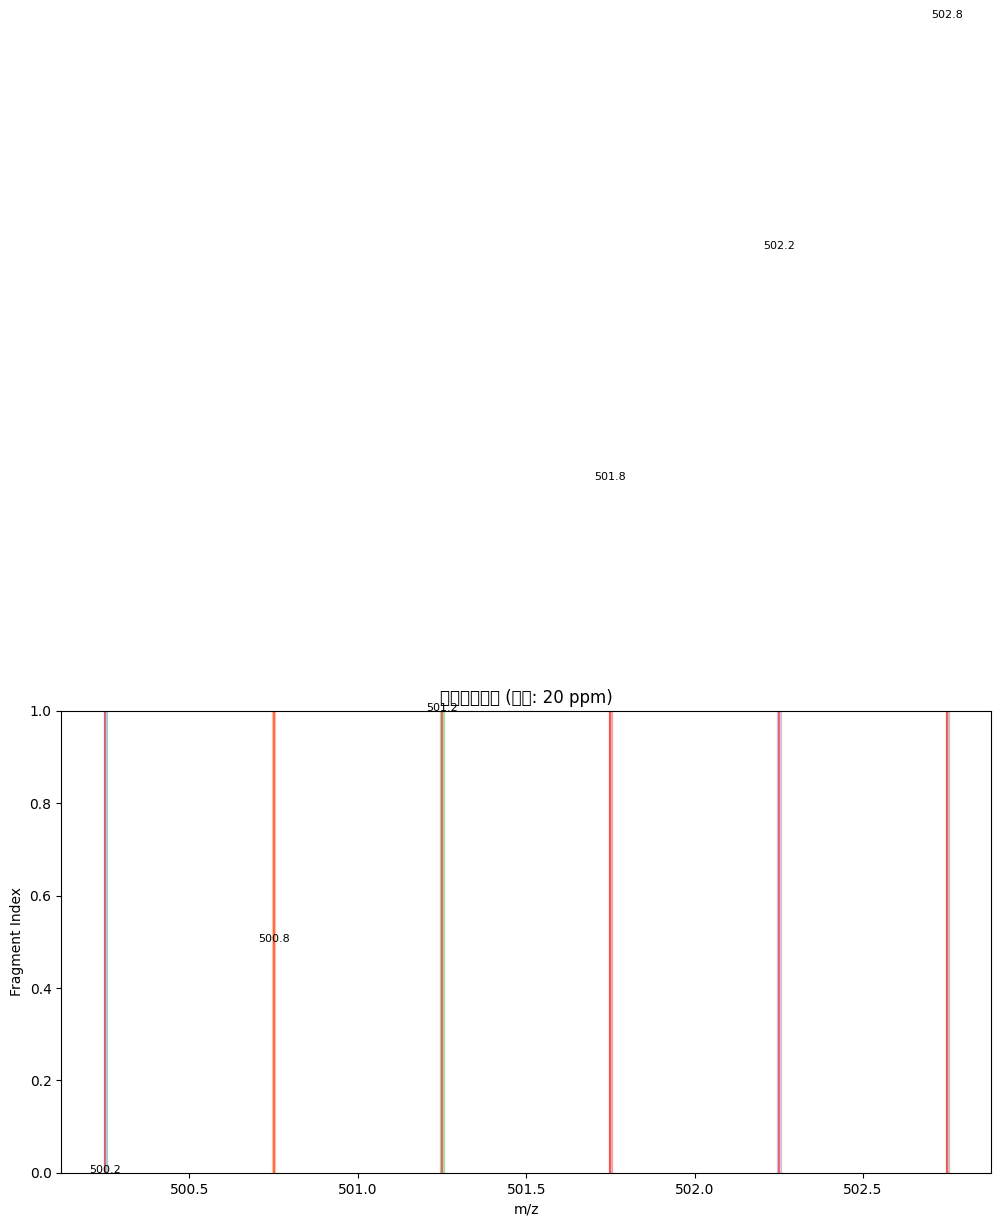

In [9]:
def visualize_extract_width(mz_values, mz_tol, mz_unit='ppm'):
    """
    可视化m/z提取窗口
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, mz in enumerate(mz_values[:10]):  # 只显示前10个
        if mz == 0:
            continue
            
        if mz_unit == 'ppm':
            half_width = mz * mz_tol * 0.000001 / 2
        else:
            half_width = mz_tol / 2
            
        # 绘制中心线
        ax.axvline(mz, color='red', linestyle='-', alpha=0.5)
        # 绘制窗口范围
        ax.axvspan(mz - half_width, mz + half_width, alpha=0.3, color=f'C{i%10}')
        ax.text(mz, i*0.5, f'{mz:.1f}', ha='center', fontsize=8)
    
    ax.set_xlabel('m/z')
    ax.set_ylabel('Fragment Index')
    ax.set_title(f'提取窗口示例 (容差: {mz_tol} {mz_unit})')
    plt.tight_layout()
    plt.show()

# 演示提取窗口
test_mz_values = ms1_data_tensor[0, :, 0].numpy()
print("MS1 m/z值和对应的提取窗口：")
visualize_extract_width(test_mz_values[test_mz_values > 0], mz_tol=20, mz_unit='ppm')

In [10]:
def simplified_extract_width(mz_to_extract, mz_unit='ppm', mz_tol=50, frag_repeat_num=5):
    """
    简化版的extract_width函数，更容易理解
    """
    print(f"\n构建提取窗口 (容差: {mz_tol} {mz_unit})")
    
    # 1. 计算容差（半宽）
    if mz_unit == "ppm":
        mz_tol_half = mz_to_extract * mz_tol * 0.000001 / 2
    else:
        mz_tol_half = torch.ones_like(mz_to_extract) * mz_tol / 2
    
    # 2. 处理特殊值
    mz_tol_half[torch.isnan(mz_tol_half)] = 0
    mz_tol_half = torch.clamp(mz_tol_half, max=0.025)  # 最大25 mDa
    
    # 3. 转换为整数单位（×1000）并确保可以被5整除
    mz_tol_half = torch.ceil(mz_tol_half * 1000 / frag_repeat_num) * frag_repeat_num
    
    # 4. 计算窗口边界
    mz_scaled = mz_to_extract * 1000
    window_min = (mz_scaled - mz_tol_half).floor()
    window_max = (mz_scaled + mz_tol_half).floor()
    
    # 5. 将窗口分成5等份
    batch_num = mz_to_extract.shape[1] // frag_repeat_num
    window_ranges = torch.stack([window_min, window_max], dim=-1)
    
    print(f"  示例窗口（第一个前体，前3个片段）：")
    for i in range(min(3, batch_num)):
        print(f"    片段{i+1}: [{window_min[0,i]:.0f}, {window_max[0,i]:.0f}] (宽度: {window_max[0,i]-window_min[0,i]:.0f})")
    
    # 6. 为每个重复调整窗口
    step_size = (window_max[:, :batch_num] - window_min[:, :batch_num]) / frag_repeat_num
    
    for repeat in range(frag_repeat_num):
        start_idx = batch_num * repeat
        end_idx = batch_num * (repeat + 1)
        
        window_ranges[:, start_idx:end_idx, 0] = window_min[:, :batch_num] + step_size * repeat
        window_ranges[:, start_idx:end_idx, 1] = window_min[:, :batch_num] + step_size * (repeat + 1) - 1
    
    # 7. 生成窗口内的所有整数m/z值
    max_width = 50  # 最多50个点
    result = torch.zeros(mz_to_extract.shape[0], mz_to_extract.shape[1], max_width)
    
    for i in range(max_width):
        result[:, :, i] = window_ranges[:, :, 0] + i
        # 超出窗口上界的设为0
        mask = result[:, :, i] > window_ranges[:, :, 1]
        result[:, :, i][mask] = 0
    
    return result, window_ranges

## 10. 执行步骤3：构建完整的提取窗口

In [11]:
# 准备数据
frag_repeat_num = 5
device = 'cpu'

# 重复MS1和MS2数据
re_ms1_data_tensor = ms1_data_tensor.repeat(1, frag_repeat_num, 1)
re_ms2_data_tensor = ms2_data_tensor.repeat(1, frag_repeat_num, 1)

print(f"重复后的形状：")
print(f"  MS1: {ms1_data_tensor.shape} -> {re_ms1_data_tensor.shape}")
print(f"  MS2: {ms2_data_tensor.shape} -> {re_ms2_data_tensor.shape}")

# 构建提取窗口
ms1_extract_width_list, ms1_ranges = simplified_extract_width(
    re_ms1_data_tensor[:, :, 0], mz_unit='ppm', mz_tol=20, frag_repeat_num=frag_repeat_num
)
ms2_extract_width_list, ms2_ranges = simplified_extract_width(
    re_ms2_data_tensor[:, :, 0], mz_unit='ppm', mz_tol=50, frag_repeat_num=frag_repeat_num
)

print(f"\n提取窗口形状：")
print(f"  MS1: {ms1_extract_width_list.shape}")
print(f"  MS2: {ms2_extract_width_list.shape}")

重复后的形状：
  MS1: torch.Size([2, 6, 9]) -> torch.Size([2, 30, 9])
  MS2: torch.Size([2, 60, 9]) -> torch.Size([2, 300, 9])

构建提取窗口 (容差: 20 ppm)
  示例窗口（第一个前体，前3个片段）：
    片段1: [500240, 500260] (宽度: 20)
    片段2: [500740, 500760] (宽度: 20)
    片段3: [501240, 501260] (宽度: 20)

构建提取窗口 (容差: 50 ppm)
  示例窗口（第一个前体，前3个片段）：
    片段1: [147105, 147115] (宽度: 10)
    片段2: [244160, 244180] (宽度: 20)
    片段3: [357240, 357260] (宽度: 20)

提取窗口形状：
  MS1: torch.Size([2, 30, 50])
  MS2: torch.Size([2, 300, 50])


## 11. 可视化最终结果

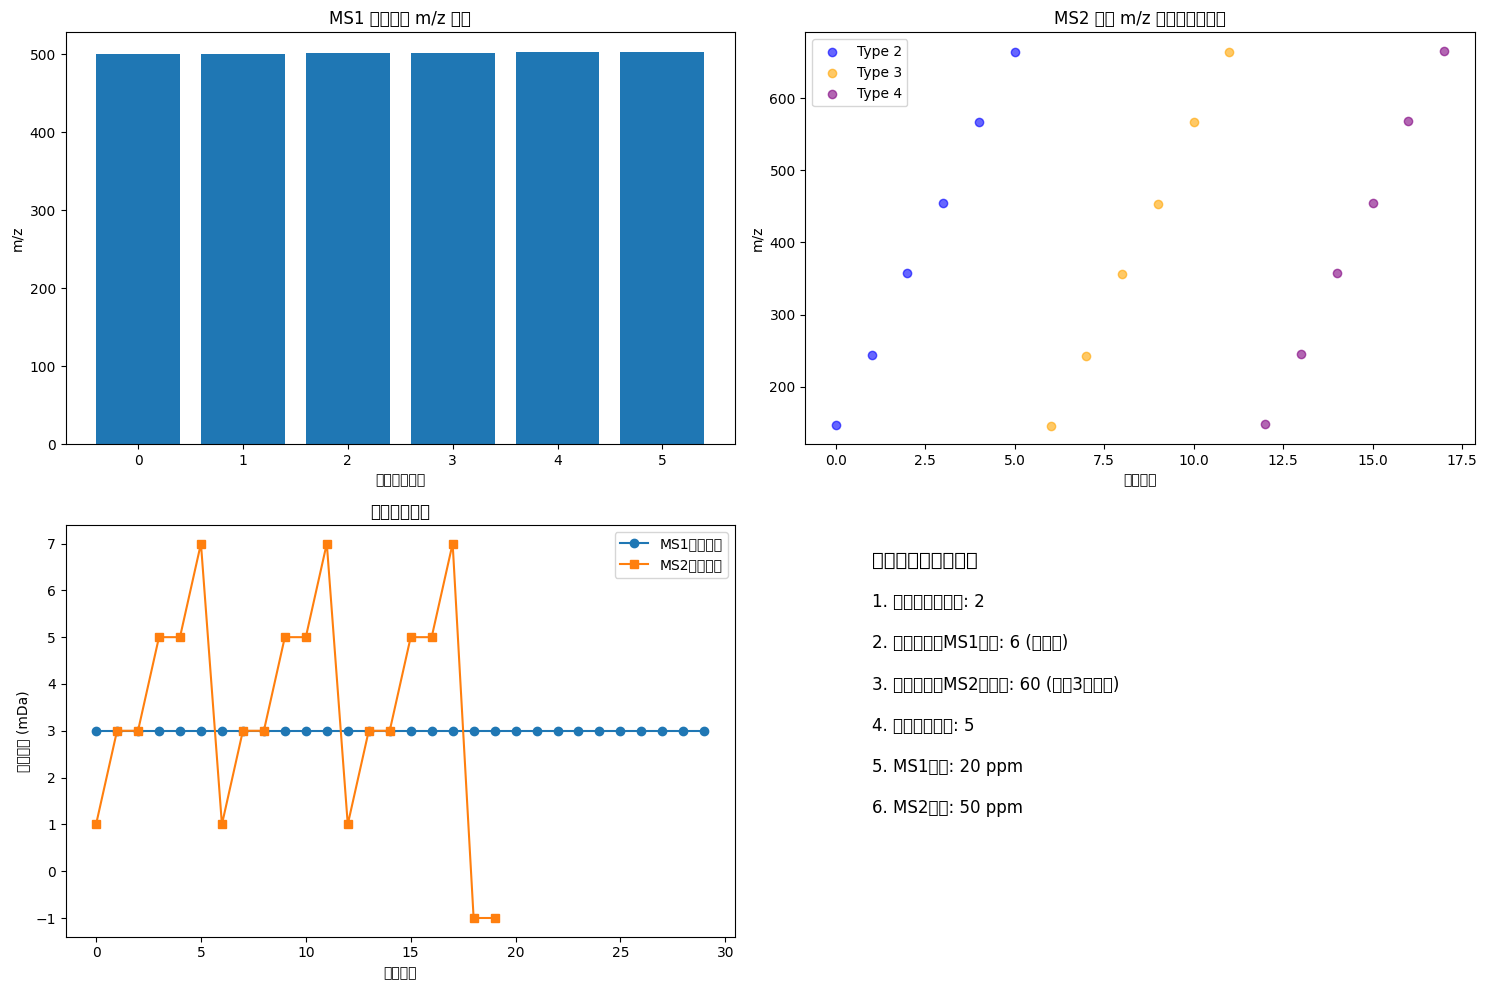

In [12]:
# 创建总结图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. MS1数据分布
ax = axes[0, 0]
ms1_mz_values = ms1_data_tensor[0, :, 0].numpy()
ms1_mz_values = ms1_mz_values[ms1_mz_values > 0]
ax.bar(range(len(ms1_mz_values)), ms1_mz_values)
ax.set_title('MS1 同位素峰 m/z 分布')
ax.set_xlabel('同位素峰索引')
ax.set_ylabel('m/z')

# 2. MS2数据分布
ax = axes[0, 1]
ms2_mz_values = ms2_data_tensor[0, :20, 0].numpy()  # 前20个
ms2_types = ms2_data_tensor[0, :20, 8].numpy()
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i, t in enumerate([2, 3, 4]):
    mask = ms2_types == t
    if mask.any():
        ax.scatter(np.where(mask)[0], ms2_mz_values[mask], 
                  label=f'Type {t}', color=colors[t], alpha=0.6)
ax.set_title('MS2 片段 m/z 分布（按类型）')
ax.set_xlabel('片段索引')
ax.set_ylabel('m/z')
ax.legend()

# 3. 提取窗口宽度
ax = axes[1, 0]
ms1_widths = (ms1_ranges[0, :, 1] - ms1_ranges[0, :, 0]).numpy()
ms2_widths = (ms2_ranges[0, :20, 1] - ms2_ranges[0, :20, 0]).numpy()
x = range(max(len(ms1_widths), len(ms2_widths)))
ax.plot(range(len(ms1_widths)), ms1_widths, 'o-', label='MS1窗口宽度')
ax.plot(range(len(ms2_widths)), ms2_widths, 's-', label='MS2窗口宽度')
ax.set_title('提取窗口宽度')
ax.set_xlabel('片段索引')
ax.set_ylabel('窗口宽度 (mDa)')
ax.legend()

# 4. 数据处理流程总结
ax = axes[1, 1]
ax.text(0.1, 0.9, '数据处理流程总结：', fontsize=14, weight='bold', transform=ax.transAxes)
ax.text(0.1, 0.8, f'1. 输入前体离子数: {len(precursors_list)}', fontsize=12, transform=ax.transAxes)
ax.text(0.1, 0.7, f'2. 每个前体的MS1峰数: 6 (同位素)', fontsize=12, transform=ax.transAxes)
ax.text(0.1, 0.6, f'3. 每个前体的MS2片段数: {ms2_data_tensor.shape[1]} (包含3种类型)', fontsize=12, transform=ax.transAxes)
ax.text(0.1, 0.5, f'4. 数据重复次数: {frag_repeat_num}', fontsize=12, transform=ax.transAxes)
ax.text(0.1, 0.4, f'5. MS1容差: 20 ppm', fontsize=12, transform=ax.transAxes)
ax.text(0.1, 0.3, f'6. MS2容差: 50 ppm', fontsize=12, transform=ax.transAxes)
ax.axis('off')

plt.tight_layout()
plt.show()

## 12. 总结

### 处理流程回顾：

1. **build_lib_matrix**：
   - 将谱库数据按前体离子分组
   - 为每个前体生成MS1数据（6个同位素峰）
   - 为每个前体生成MS2数据（片段×3种类型）
   - 提取前体离子的基本信息

2. **步骤1 - 张量转换**：
   - 将numpy数组转换为PyTorch张量
   - 便于后续的GPU加速计算

3. **步骤2 - MS2数据处理**：
   - 调整m/z值，加入类型相关的偏移
   - 这有助于区分不同类型的片段

4. **步骤3 - 构建提取窗口**：
   - 为每个m/z值计算提取窗口（基于ppm容差）
   - 将数据重复5次，每次提取窗口的不同部分
   - 生成窗口内所有整数m/z值的列表

### 关键概念：

- **同位素峰**：由于碳13等同位素的存在，每个分子会产生多个峰
- **片段类型**：library(2)、light(3)、isotope(4)代表不同的处理方式
- **提取窗口**：在实际测量中，需要在理论m/z值附近一定范围内搜索信号
- **数据重复**：通过5次重复，可以更精细地划分提取窗口

In [13]:
# 最终输出数据结构
print("=== 最终数据结构 ===")
print(f"\n1. precursors_list: {len(precursors_list)} 个前体")
print(f"   格式: [前体ID, decoy标记]")
print(f"   示例: {precursors_list[0]}")

print(f"\n2. ms1_data_tensor: {ms1_data_tensor.shape}")
print(f"   维度: [前体数, MS1峰数, 特征数]")
print(f"   特征: [m/z, 前体电荷, 片段电荷, 强度, ...]")

print(f"\n3. ms2_data_tensor: {ms2_data_tensor.shape}")
print(f"   维度: [前体数, 片段数×3, 特征数]")

print(f"\n4. ms1_extract_width_list: {ms1_extract_width_list.shape}")
print(f"   维度: [前体数, MS1峰数×5, 窗口点数]")
print(f"   用途: 定义每个MS1峰的m/z搜索范围")

print(f"\n5. ms2_extract_width_list: {ms2_extract_width_list.shape}")
print(f"   维度: [前体数, 片段数×5, 窗口点数]")
print(f"   用途: 定义每个MS2片段的m/z搜索范围")

=== 最终数据结构 ===

1. precursors_list: 2 个前体
   格式: [前体ID, decoy标记]
   示例: ['PEPTIDE1+2', 0]

2. ms1_data_tensor: torch.Size([2, 6, 9])
   维度: [前体数, MS1峰数, 特征数]
   特征: [m/z, 前体电荷, 片段电荷, 强度, ...]

3. ms2_data_tensor: torch.Size([2, 60, 9])
   维度: [前体数, 片段数×3, 特征数]

4. ms1_extract_width_list: torch.Size([2, 30, 50])
   维度: [前体数, MS1峰数×5, 窗口点数]
   用途: 定义每个MS1峰的m/z搜索范围

5. ms2_extract_width_list: torch.Size([2, 300, 50])
   维度: [前体数, 片段数×5, 窗口点数]
   用途: 定义每个MS2片段的m/z搜索范围
